In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
import numpy as np

In [2]:
folder = 'C:/Users/danie/OneDrive/Ambiente de Trabalho/VSCode/AI/chessMind/chessMind/data-chesscom'
image_size = (224, 224)
batch_size = 16

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object
datagen = ImageDataGenerator()

In [4]:
# Create generators for the train and test data
train_gen = datagen.flow_from_directory(
    folder + '/train', # directory that contains the train images
    target_size = image_size, # resize the images to the specified size
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=True  
)

test_gen = datagen.flow_from_directory(
    folder + '/test',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=False 
)

Found 79 images belonging to 13 classes.
Found 79 images belonging to 13 classes.


In [5]:
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions

model = VGG16(weights='imagenet')
model.summary()

553467096/553467096 [==============================] - 91s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x)  # flatten from convolution tensor output  
x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(500, activation='relu')(x)
predictions = Dense(13, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

58889256/58889256 [==============================] - 10s 0us/step


In [7]:
epochs = 10

history = model.fit(
    train_gen, 
    epochs=epochs,
    verbose = 1,
    validation_data=test_gen
    )

model.save_weights('model_VGG16_digital.h5')
model.save('model_digital.h5')

Epoch 1/10
5/5 [==============================] - 79s 17s/step - loss: 27.5632 - categorical_accuracy: 0.3797 - val_loss: 19.4521 - val_categorical_accuracy: 0.6582
Epoch 2/10
5/5 [==============================] - 71s 16s/step - loss: 10.6039 - categorical_accuracy: 0.7848 - val_loss: 1.0680 - val_categorical_accuracy: 0.9114
Epoch 3/10
5/5 [==============================] - 70s 16s/step - loss: 1.9497 - categorical_accuracy: 0.9241 - val_loss: 4.1597e-05 - val_categorical_accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - 72s 16s/step - loss: 2.2137e-04 - categorical_accuracy: 1.0000 - val_loss: 4.4914e-05 - val_categorical_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 71s 16s/step - loss: 0.1453 - categorical_accuracy: 0.9620 - val_loss: 0.2557 - val_categorical_accuracy: 0.9873
Epoch 6/10
5/5 [==============================] - 69s 15s/step - loss: 0.2550 - categorical_accuracy: 0.9873 - val_loss: 1.2072e-08 - val_categorical_accuracy: 1.0000
Epo

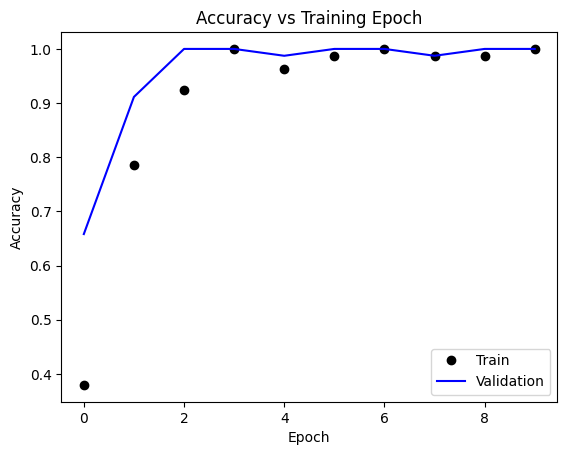

In [9]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(history.history['categorical_accuracy'], 'ko')
plt.plot(history.history['val_categorical_accuracy'], 'b')

plt.title('Accuracy vs Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation']);

C:\Users\danie\AppData\Local\Temp\ipykernel_6904\1434490548.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_gen)


0.09875


<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

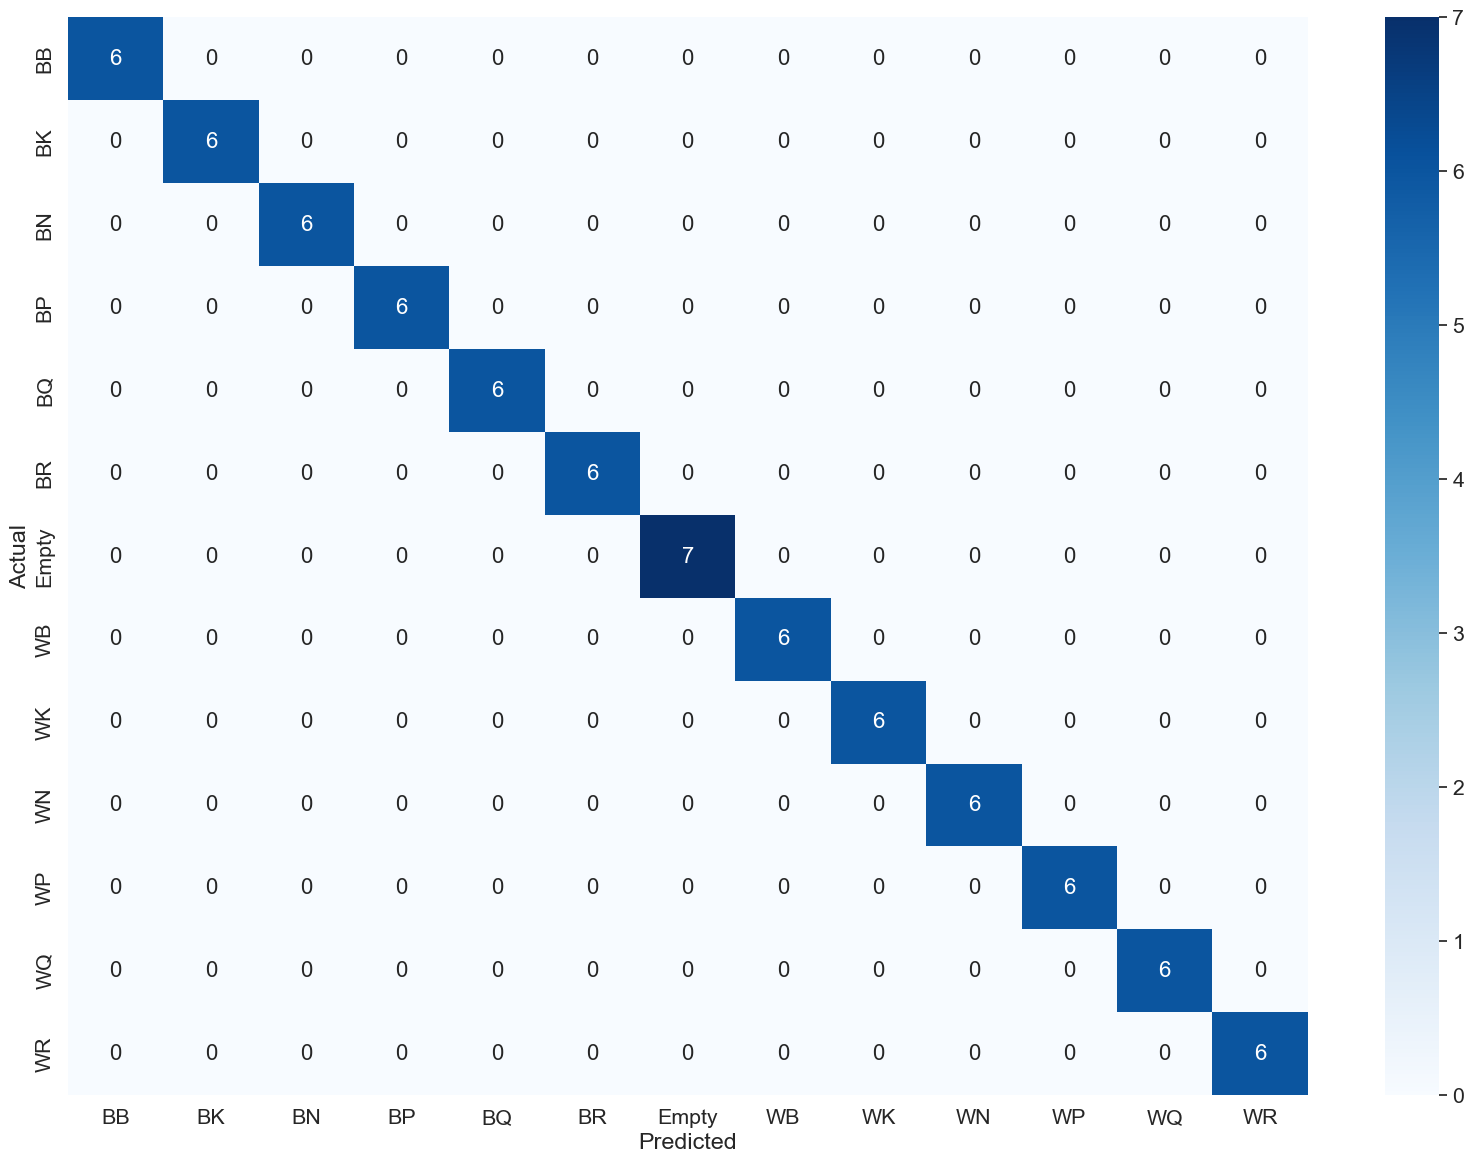

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['BB', 'BK', 'BN', 'BP', 'BQ', 'BR', 'Empty', 'WB', 'WK', 'WN', 'WP', 'WQ', 'WR']

test_gen.reset()
Y_pred = model.predict_generator(test_gen)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)
print(sum(y_pred==classes)/800)


data = confusion_matrix(classes, y_pred)
df_cm = pd.DataFrame(data, columns=target_names, index = target_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,14))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [14]:
print('Confusion Matrix')
print(data)
print('Classification Report')
print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))

Confusion Matrix
[[ 196    0    2    2    0    0    0    0    0    0    0    0    0]
 [  34  163    1    1    0    1    0    0    0    0    0    0    0]
 [   5    0  190    2    0    2    1    0    0    0    0    0    0]
 [   4    0    0  576    0    0   20    0    0    0    0    0    0]
 [  35    0    1    3  159    1    1    0    0    0    0    0    0]
 [   2    0    0    5    0  193    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1000    0    0    0    0    0    0]
 [   2    0    0    0    0    0    0  193    0    0    4    0    1]
 [   0    0    0    0    0    0    0   14  176    5    0    5    0]
 [   0    0    0    0    0    0    0    0    0  199    0    0    1]
 [   1    0    0    1    0    0    5    0    0    0  593    0    0]
 [   0    0    0    0    1    0    0    7    0    2    0  190    0]
 [   0    0    0    0    0    0    1    0    0    1    2    0  196]]
Classification Report
              precision    recall  f1-score   support

          BB       0.